# Why EOReader?

EOReader has been designed to:
- ✅ **simplify and harmonize the use of satellite data**. 
   - load data **sensor-agnostically**
   - wide **range of supported sensors**
   - make algorithms **easy to update** with new sensors
   - **automatic** preprocessing and spectral index computation
- ✅ **increase the reliability** of the production tools
- ✅ **be opensource** and **community friendly**

---

Let's illustrate this with an example.
The purpose of this notebook will be to load a **NIR band in reflectance** from different products: an archived Landsat-9, a Pléiades and an archived Sentinel-2.

We will start to see how it's done first with `eoreader` and then with only `rasterio`.
We could have compared also to how it's done with `rioxarray`, but this will be for another time.

## Imports

In [1]:
import os
import numpy as np
import rasterio
import eoreader
from eoreader.reader import Reader
from eoreader.bands import NIR
from rasterio.plot import show, adjust_band
from matplotlib import pyplot as plt

In [2]:
# Create logger
import logging
from sertit import logs

logger = logging.getLogger("eoreader")
logs.init_logger(logger)

## Data preparation

Link the paths of the three different products.

In [3]:
## Base folder
prod_folder = os.path.join("/home", "ds2_db3", "CI", "eoreader", "optical")

# Landsat-9 OLI-TIRS collection 2 (archived in a tar file)
l9_path = os.path.join(prod_folder, "LC09_L1TP_200030_20220201_20220201_02_T1.tar")

# Pléiades-Néo, as a folder (extracted data)
pneo_path = os.path.join(prod_folder, "IMG_01_PNEO3_PMS")

# Sentinel-2 L2A (archived in a zip file)
s2_path = os.path.join(prod_folder, "S2A_MSIL1C_20200824T110631_N0209_R137_T30TTK_20200824T150432.SAFE.zip")

# Group all these paths
paths = [l9_path, pneo_path, s2_path]

## EOReader

With `eoreader`, you can easily access archived and extracted data, without paying attention at where everything is stored.

By default, your band nodata is set and the data converted to reflectance.

Everything is done with `xarray`, so you can easily access the plot function.

And last but not least, you just can loop over the paths, like if they were of the same kind!

2025-12-22 17:04:17,891 - [INFO] - Open LC09_L1TP_200030_20220201_20220201_02_T1.tar product
2025-12-22 17:04:18,501 - [INFO] - Load NIR band of 20220201T104852_L9_200030_OLI_TIRS
2025-12-22 17:04:18,502 - [DEBUG] - Loading bands ['NIR']
2025-12-22 17:04:18,503 - [DEBUG] - Read NIR
2025-12-22 17:04:18,744 - [DEBUG] - Manage nodata for band NIR
2025-12-22 17:04:18,794 - [DEBUG] - Converting NIR to reflectance (if needed)
2025-12-22 17:04:18,798 - [DEBUG] - Clip the reflectance array to 0 as minimum value (in some cases, reflectance can have higher value than 1)
2025-12-22 17:04:27,856 - [INFO] - Plot this NIR band


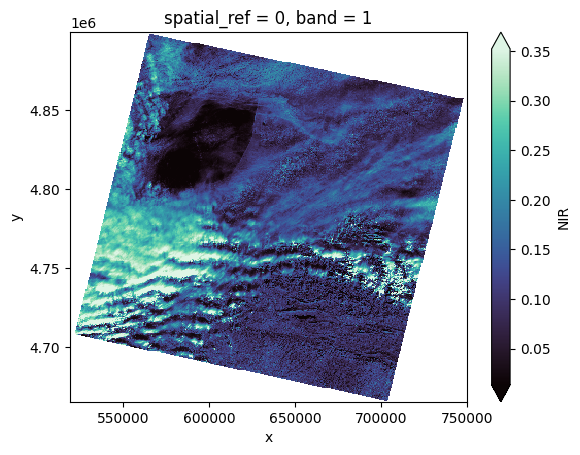

2025-12-22 17:04:28,447 - [INFO] - Open IMG_01_PNEO3_PMS product
2025-12-22 17:04:28,666 - [INFO] - Load NIR band of 20220118T215211_PNEO_ORT_PMS_000007338
2025-12-22 17:04:28,667 - [DEBUG] - Loading bands ['NIR']
2025-12-22 17:04:28,671 - [DEBUG] - Read NIR
2025-12-22 17:04:28,732 - [DEBUG] - Manage nodata for band NIR
2025-12-22 17:04:28,732 - [DEBUG] - Load nodata
2025-12-22 17:04:28,826 - [DEBUG] - Rasterizing ROI mask
2025-12-22 17:05:14,459 - [DEBUG] - Set nodata mask
2025-12-22 17:05:15,697 - [DEBUG] - Converting NIR to reflectance (if needed)
2025-12-22 17:07:13,553 - [INFO] - Plot this NIR band


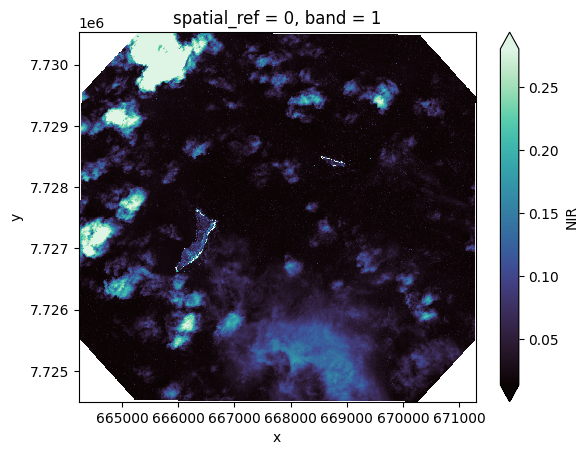

2025-12-22 17:07:49,349 - [INFO] - Open S2A_MSIL1C_20200824T110631_N0209_R137_T30TTK_20200824T150432.SAFE.zip product
2025-12-22 17:07:49,370 - [INFO] - Load NIR band of 20200824T110631_S2_T30TTK_L1C_150432
2025-12-22 17:07:49,371 - [DEBUG] - Loading bands ['NIR']
2025-12-22 17:07:49,373 - [DEBUG] - Read NIR
2025-12-22 17:07:49,472 - [DEBUG] - Manage nodata for band NIR
2025-12-22 17:07:51,019 - [DEBUG] - Converting NIR to reflectance (if needed)
2025-12-22 17:08:16,257 - [INFO] - Plot this NIR band


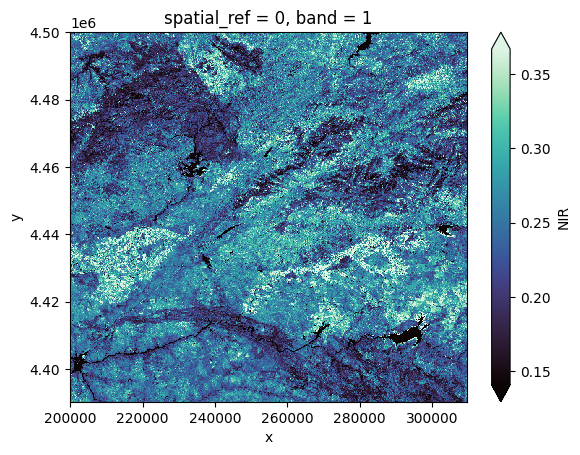

In [4]:
%matplotlib inline
reader = Reader()
for path in paths:
    # Open the product
    logger.info(f"Open {os.path.basename(path)} product")
    prod = reader.open(path)
    
    # Load NIR
    # The condensed name is an harmonized way of naming the different satellite products
    logger.info(f"Load NIR band of {prod.condensed_name}")
    nir = prod.load(NIR)[NIR]
    
    # Plot
    logger.info(f"Plot this NIR band")
    nir[:, ::20, ::20].plot(cmap="mako", robust=True)
    plt.show()

## Rasterio

For `rasterio`, of course the code will be more complex as this library is way more generic and low-level than EOReader.

### NIR for Landsat-9

For Landsat-9, the NIR band is the 5th band.

⚠️The Landsat-9 product is archived in a tar file, so be careful how you read the NIR file.

In [5]:
l9_nir_path = rf"tar://{l9_path}!LC09_L1TP_200030_20220201_20220201_02_T1_B5.TIF"

with rasterio.open(l9_nir_path) as l9_nir_ds:
    l9_nir = l9_nir_ds.read()
    l9_tr = l9_nir_ds.transform

Here we have the Landsat-9 band as a `numpy` array, but it is not in reflectance and the nodata is not set.

In [6]:
# First convert the band to float (as we want reflectance values and why not nans in place of nodata)
l9_nir = l9_nir.astype(np.float32)

# Set nodata, for landsat it is where the band is null (before converting to reflectance!)
l9_nir = np.where(l9_nir==0, np.nan, l9_nir)

# Convert to reflectance
# We can look in the metadata file (LC09_L1TP_200030_20220201_20220201_02_T1_MTL.xml) inside the zip to go faster for this specific band.
# However, you will need to repeat this operation for any other band or product
# Or set it in stone, but be careful as the specification may change...
l9_nir_c_add = -0.100000
l9_nir_c_mul = 2.0000E-05
l9_nir_refl = l9_nir * l9_nir_c_mul + l9_nir_c_add

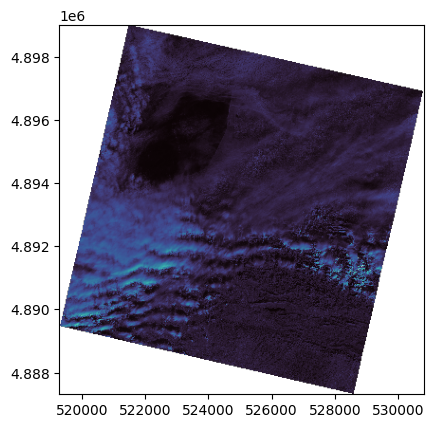

<Axes: >

In [7]:
show(l9_nir_refl[:, ::20, ::20], transform=l9_tr, cmap='mako', adjust=True)

### NIR for Pleiades

For Pleiades, the NIR band is the 4th.

The Pleaides product is a stack, so only read the 4th band. 

⚠️It is also best to read the DIMAP.xml file rather than the .JP2 as the product may be tiled.

In [9]:
pneo_nir_path = os.path.join(pneo_path, "DIM_PNEO3_202201182152117_PMS_ORT_PWOI_000007338_1_1_F_1.XML")

with rasterio.open(pneo_nir_path) as pneo_nir_ds:
    pneo_nir = pneo_nir_ds.read()
    pneo_tr = pneo_nir_ds.transform

We still need to set the nodata. 

In [10]:
# Convert the band to float for consistency
pneo_nir = pneo_nir.astype(np.float32)

# Set nodata, for PNEO it is where the band is null
pneo_nir = np.where(pneo_nir==0, np.nan, pneo_nir)

# Scale to reflectance
pneo_nir /= 10000

⚠️ And we are lucky, according to the metadata file, the Pléiades-Néo data has been ordered in reflectance!
Indeed, we can find `<RADIOMETRIC_PROCESSING>BASIC</RADIOMETRIC_PROCESSING>` in the metadata file, that means we don't need to convert the data from DN to reflectance.

This would have been too long to be done here:
- first we need to convert DN to TOA radiance,
- then convert it to TOA reflectance,  
as seen in the [Appendix D of the Pleiades User Guide](https://www.intelligence-airbusds.com/automne/api/docs/v1.0/document/download/ZG9jdXRoZXF1ZS1kb2N1bWVudC01NTY0Mw==/ZG9jdXRoZXF1ZS1maWxlLTU1NjQy/airbus-pleiades-imagery-user-guide-15042021.pdf#page=94)

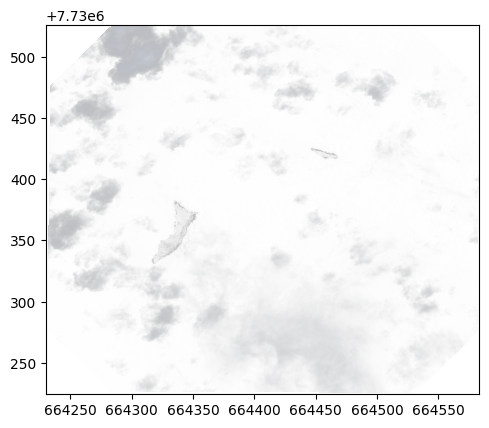

In [27]:
show(pneo_nir[:, ::20, ::20], transform=pneo_tr, cmap='mako', adjust=True)


### NIR for Sentinel-2

For Sentinel-2, there are two NIR bands, one with a spatial resolution of 10 meters (`8A`) but with a lower spectral resolution than the 20m NIR band (`08`). So if you work at 20m of resolution it will be better to load the `08` band.

⚠️The Sentinel-2 product is archived in a zip file, so be careful how you read the NIR file.

⚠️The Sentinel-2 bands are not easy to retrieve, you should look in the `GRANULE` and into the `IMG_DATA` folder.
This is product specific!

In [24]:
s2_nir_path = os.path.join(
    f"zip://{s2_path}",
    "S2A_MSIL1C_20200824T110631_N0209_R137_T30TTK_20200824T150432.SAFE!",
    "GRANULE",
    "L1C_T30TTK_A027018_20200824T111345",
    "IMG_DATA",
    "T30TTK_20200824T110631_B08.jp2"
)

with rasterio.open(s2_nir_path) as s2_nir_ds:
    s2_nir = s2_nir_ds.read()
    s2_tr = s2_nir_ds.transform

Set the nodata and convert into reflectance!

⚠️⚠️⚠️
This seems easy fore Sentinel-2 data, but pay attention that if the product has been acquired after 25/01/2022 (with the [processing baseline](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/processing-baseline) 04.00), an offset has been added!

And if the processing baseline is less than 02.07 for L2A products (L2Ap) (before 06/11/2018), the bands are not geocoded and you need to do it manually...

In [25]:
# First convert the band to float (as we want reflectance values and why not nans in place of nodata)
s2_nir = s2_nir.astype(np.float32)

# Set nodata, for Sentinel-2 it is where the band is null
s2_nir = np.where(s2_nir==0, np.nan, s2_nir)

# Convert to reflectance
s2_nir_c_add = 0  # This changes with baseline 04.00!
s2_nir_c_mul = 1/10000
s2_nir_refl = s2_nir * s2_nir_c_mul + s2_nir_c_add

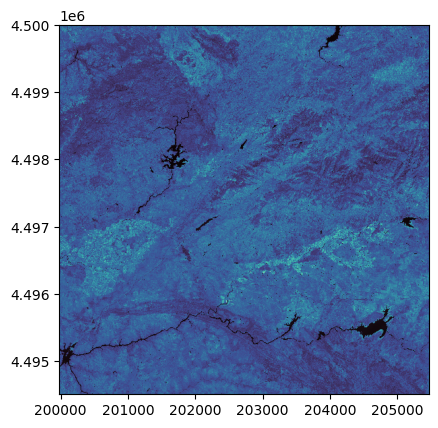

<Axes: >

In [26]:
show(s2_nir_refl[:, ::20, ::20], transform=s2_tr, cmap='mako', adjust=True)

## Overview of the simplifications

What you get in exchange of a bit of speed:

![pro/contras](https://zupimages.net/up/22/27/6yz0.png)
